In [468]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## 1) Some basic information about the files

In [469]:
events = pd.read_csv("Customer1/events.csv")
calls = pd.read_csv("Customer1/calls.csv")
company = pd.read_csv("Customer1/companies.csv")
people = pd.read_csv("Customer1/people.csv")
opport = pd.read_csv("Customer1/opportunities.csv")
events = events.rename(columns={"date": "event_date"})

In [470]:
print('the size of each file: ')
print('events:', len(events))
print('calls:', len(calls))
print('company:', len(company))
print('people:', len(people))
print('opportunity:', len(opport))


the size of each file: 
events: 111525
calls: 367005
company: 31110
people: 64429
opportunity: 3213


In [471]:
print('the columns of each file: ')
print('events: ', events.columns)
print('calls: ', calls.columns)
print('company: ', company.columns)
print('people: ', people.columns)
print('opportunity: ', opport.columns)

the columns of each file: 
events:  Index(['event_date', 'activity_action', 'activity_type', 'contact_id'], dtype='object')
calls:  Index(['date', 'timestamp', 'call_disposition', 'contact_id'], dtype='object')
company:  Index(['company_id', 'industry', 'employee_range'], dtype='object')
people:  Index(['job_level', 'job_function', 'company_id', 'contact_id'], dtype='object')
opportunity:  Index(['company_id', 'created_date'], dtype='object')


In [472]:
events['activity_action'].value_counts()


view                  36547
open                  29646
fill_out              19870
click                 13464
filled_out_form       11789
attended_in_person      209
Name: activity_action, dtype: int64

In [473]:
events['activity_type'].value_counts()
    

known_web_visit    36547
form_fill          31659
email_open         29646
email_click        13464
attended_event       209
Name: activity_type, dtype: int64

* it can be seen that fill_out and filled_out_form are the same events, so I will use activity_type to merge the table in order to avoid duplicated while merging tables

## 2) Merge a new table

### a) Create new tables for events and calls without duplicates

In [474]:
new_events = events.groupby(['contact_id', 'event_date', 'activity_type'], as_index = False).count().rename(columns = {'activity_action':'activity_count'})   
new_calls = calls.groupby(['contact_id', 'date', 'call_disposition'], as_index = False).count().rename(columns = {'timestamp':'call_count'})

print('the size of new tables: ')
print('new_events: ', len(new_events))
print('new_calls: ', len(new_calls))

the size of new tables: 
new_events:  99780
new_calls:  266201


In [475]:
new_events.head()

,contact_id,event_date,activity_type,activity_count
0,40008cab9a95789c6,2019-08-20,form_fill,1
1,40008cab9a95789c6,2019-08-20,known_web_visit,1
2,400097495c858cc5b,2019-10-10,form_fill,2
3,4000bb6585ca64a04,2019-08-01,form_fill,1
4,4000bb6585ca64a04,2019-08-01,known_web_visit,1


In [476]:
new_calls.head()


,contact_id,date,call_disposition,call_count
0,4000047a5b09764c,2019-09-19,No Answer,2
1,400008b800968b87b,2019-09-16,No Answer,1
2,400008b800968b87b,2019-09-20,No Answer,1
3,400008b800968b87b,2019-09-24,No Answer,1
4,400008b800968b87b,2019-10-02,No Answer,1


### b) Merging a new table

In [477]:
a = new_calls.merge(new_events, on = 'contact_id', how = 'inner')
b = a.merge(people, on = 'contact_id', how = 'inner')
merge = b.merge(company, on = 'company_id', how = 'inner')
merge.head()

,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,company_id,industry,employee_range
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,e215e54457e5469,Manufacturing,0 - 9
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99


In [478]:
opp = np.zeros(len(merge))
for i in range(len(merge)):
    if merge['company_id'][i] in opport['company_id'].values:
        opp[i] = 1

In [479]:
merge['opportunity'] = opp
del merge['company_id']
merge.head()

,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,industry,employee_range,opportunity
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,Healthcare and Medical,0 - 9,0.0
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,Healthcare and Medical,0 - 9,0.0
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,Manufacturing,0 - 9,0.0
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,Software and Technology,50 - 99,0.0
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,Software and Technology,50 - 99,0.0


### c) Delete all of the None values

> it turns out that there is no None values

In [480]:
d = d.dropna()
d = d.reset_index(drop=True)
print('size of the table after deleting the None values:', len(merge))

size of the table after deleting the None values: 535307


## 3) Feature Engineering

### a) Adding new features

#### i) Feature one: the day difference between call date and event date

In [481]:
merge['event_date'] =  pd.to_datetime(merge['event_date'])
merge['event_day'] = pd.Series([merge['event_date'][i].strftime('%a') for i in range(len(merge))])
merge['date'] =  pd.to_datetime(merge['date'])
merge['diff'] = (merge['date'] - merge['event_date']).dt.days


In [482]:
merge.head()

,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,industry,employee_range,opportunity,event_day,diff
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,Healthcare and Medical,0 - 9,0.0,Tue,0
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,Healthcare and Medical,0 - 9,0.0,Tue,0
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,Manufacturing,0 - 9,0.0,Thu,0
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,Software and Technology,50 - 99,0.0,Thu,0
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,Software and Technology,50 - 99,0.0,Thu,0


Text(0.5, 1.0, 'Day Different Between Events Day and Call Day')

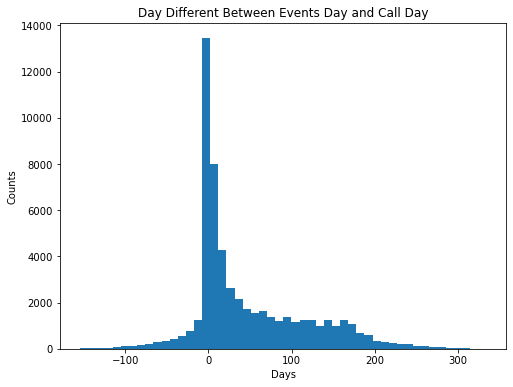

In [483]:
df = merge[merge['call_disposition'].str.contains('MC')]
plt.figure(figsize=(8,6))
plt.hist(x = df['diff'], bins = 50)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.title('Day Different Between Events Day and Call Day')

> * the plot of the day difference using the calls with meaningful conversation
> * it can be seen that most of the meaningful conversation was made within few days after the customers' activities related to 6Sense

#### ii) Feature two: the total count of activity action for each contact_id

In [484]:
total_count = merge.groupby('contact_id', as_index = False).size().rename(columns={'size':'total count'})

merge = merge.merge(total_count, on = 'contact_id')

merge.head()


,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,industry,employee_range,opportunity,event_day,diff,total count
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,Healthcare and Medical,0 - 9,0.0,Tue,0,2
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,Healthcare and Medical,0 - 9,0.0,Tue,0,2
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,Manufacturing,0 - 9,0.0,Thu,0,1
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,Software and Technology,50 - 99,0.0,Thu,0,28
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,Software and Technology,50 - 99,0.0,Thu,0,28


In [613]:
total_c = merge[['call_disposition', 
                 'activity_type', 
                 'call_count']].groupby(['call_disposition', 
                                         'activity_type']).count().rename(columns={'call_count':'total count'})

total_c

total count
call_disposition       activity_type               
Bad Number             attended_event             6
                       email_click             1152
                       email_open              2694
                       form_fill               2815
                       known_web_visit         4499
...                                             ...
Wrong Point of Contact attended_event             4
                       email_click              207
                       email_open               320
                       form_fill                287
                       known_web_visit          389

[84 rows x 1 columns]

In [521]:
merge['call_disposition'].unique()

array(['MC - No Need', 'No Answer', 'Bad Number', 'Left Voicemail',
       'MC - No Timeline', 'Call Back Later', 'MC - Meeting Confirmation',
       'MC - Meaningful Conversation', 'MC - No Budget', 'MC - MQL/QMA',
       'MC - No Technical Fit', 'MC - No Authority',
       'Discovery Call Scheduled', 'Left Live Message',
       'No Longer w/ Company', 'Wrong Point of Contact',
       'Call - No Answer', 'Voicemail- Left Voicemail Drop'], dtype=object)

In [490]:
merge['activity_type'].unique()

array(['form_fill', 'known_web_visit', 'email_click', 'email_open',
       'attended_event'], dtype=object)

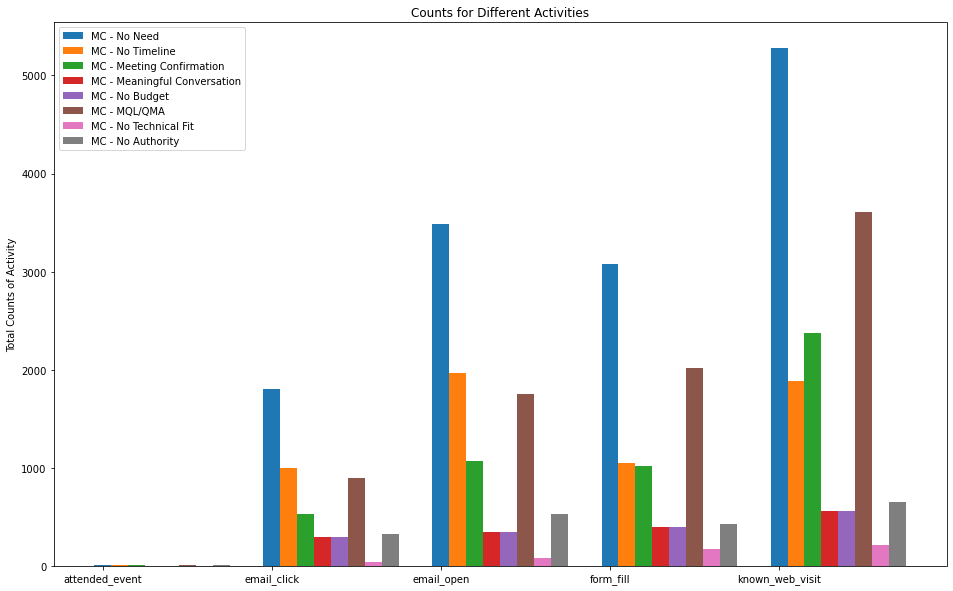

In [620]:
labels = ['attended_event', 'email_click', 'email_open', 'form_fill', 'known_web_visit']
legends = ['MC - No Need', 'MC - No Timeline', 'MC - Meeting Confirmation', 
           'MC - Meaningful Conversation', 'MC - No Budget', 'MC - MQL/QMA', 
           'MC - No Technical Fit', 'MC - No Authority',]

# call_dis = merge.groupby(['call_disposition', 'activity_type'])[['total count']].sum()

# set the height of the bars
no_need = total_c.loc[('MC - No Need')]['total count'].values
no_time = total_c.loc[('MC - No Timeline')]['total count'].values
meet_conf = total_c.loc[('MC - Meeting Confirmation')]['total count'].values
m_c = total_c.loc[('MC - Meaningful Conversation')]['total count'].values
no_budget = total_c.loc['MC - No Budget']['total count'].values
no_budget = np.append(0, no_budget)
mc_mql = total_c.loc['MC - MQL/QMA']['total count'].values
no_tec = total_c.loc['MC - No Technical Fit']['total count'].values
no_tec = np.append(0, no_tec)
no_aut = total_c.loc['MC - No Authority']['total count'].values
# no_answer = total_c.loc['No Answer']['total count'].values
# bad_num = total_c.loc['Bad Number']['total count'].values

# plt.figure(figsize=(12,10))
# set the width of the bars
width = 0.1
fig, ax = plt.subplots(figsize=(16,10))

# Set position of bar on X axis 
x1 = np.arange(len(labels)) 
x2 = [x + width for x in x1] 
x3 = [x + width for x in x2]
x4 = [x + width for x in x3]
x5 = [x + width for x in x4]
x6 = [x + width for x in x5]
x7 = [x + width for x in x6]
x8 = [x + width for x in x7]
# x9 = [x + width for x in x8]
# x10 = [x + width for x in x9]

rects1 = ax.bar(x1, no_need, width, label=legends[0], align='center')
rects2 = ax.bar(x2, no_time, width, label=legends[1], align='center')
rects3 = ax.bar(x3, meet_conf, width, label=legends[2], align='center')
rects4 = ax.bar(x4, no_budget, width, label=legends[3], align='center')
rects5 = ax.bar(x5, no_budget, width, label=legends[4], align='center')
rects6 = ax.bar(x6, mc_mql, width, label=legends[5], align='center')
rects7 = ax.bar(x7, no_tec, width, label=legends[6], align='center')
rects8 = ax.bar(x8, no_aut, width, label=legends[7], align='center')
# rects9 = ax.bar(x9, no_answer, width, label='no answer', align='center')
# rects10 = ax.bar(x10, bad_num, width, label='bad number', align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Total Counts of Activity')
ax.set_title('Counts for Different Activities')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.legend()



In [485]:
# target = d['call_day']
# features = d.drop(['call_day','call_month'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# target = d['call_day']
# features = d.drop(['call_day','call_month'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# target = d['call_day']
# features = d.drop(['call_day','call_month', 'oppor'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)

# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# target = d['call_day']
# features = d.drop(['call_day'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# knn = KNeighborsClassifier(n_neighbors = 3)                 
# knn.fit(x_train, y_train)                                     

# training_accuracy = knn.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = knn.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)


In [ ]:
# svc = SVC(kernel='poly', C=100)                                             
# svc.fit(x_train, y_train)                                       

# training_accuracy = svc.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = svc.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# perceptron = Perceptron()                           
# perceptron.fit(x_train, y_train)                                     

# training_accuracy = perceptron.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = perceptron.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
a = company.merge(people, how = 'left', on = 'company_id')
b = opport.merge(a, how = 'left', on = 'company_id')
c = b.merge(calls, how = 'left', on = 'contact_id')
d = c.merge(events.iloc[:, 0:5], on = 'contact_id')
d['timestamp'] =  pd.to_datetime(d['timestamp'])
d['day'] = [e.strftime('%a') for e in d['timestamp']]
d['hour'] = [e.strftime('%H') for e in d['timestamp']]
d
# employee_range

In [ ]:
import seaborn as sns
t = d.groupby(['job_level', 'call_disposition'], as_index = False)[['company_id']].count()
t = t.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t['job_level'], y = t['count'], hue = t['call_disposition'])
plt.title("Activity (Calls) Count by Different Job Level ")
plt.savefig('sample1.png')
# the frequency of different job level people response to the call

In [ ]:
t1 = d.groupby(['job_level', 'activity_type'], as_index = False)[['company_id']].count()
t1 = t1.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t1['job_level'], y = t1['count'], hue = t1['activity_type'])
plt.title("Activity (Emails) Count by Different Job Level ", fontsize=20)
plt.savefig('sample2.png')

In [ ]:
t3 = d.groupby(['hour', 'call_disposition'], as_index = False)[['company_id']].count()
t3 = t3.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t3['hour'], y = t3['count'], hue = t3['call_disposition'])
plt.title("Activity (Calls) Count by Hours")
plt.savefig('sample3.png')

In [ ]:
t4 = d.groupby(['day', 'job_level'], as_index = False)[['company_id']].count()
t4 = t4.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t4['day'], y = t4['count'], hue = t4['job_level'])
plt.title("Daily Activity Count by Different Job Level ")
plt.savefig('sample4.png')

In [ ]:
d.to_csv('d.csv')

In [ ]:
company.head()
company

In [ ]:
opport.merge(company, on = 'company_id', how = 'left')

In [ ]:
c_calls.head()
c_calls

In [ ]:
c_events.head()
c_events

In [ ]:
c_opport.head()
c_opport

In [ ]:
c_people.head()
c_people

In [ ]:
c_company.head()
c_company